In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
df_data=pd.read_csv("orange_small_churn_data.csv")
name=['target']
target=pd.read_csv("orange_small_churn_labels.csv",names=name)
df_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN


### Primary data analysis

__Drop the columns with 100% of missings__

In [3]:
to_drop=[]
for i in df_data.columns:
    if df_data.isna().sum()[i]/df_data.shape[0]==1:
#         print(i,df_data.isna().sum()[i]/df_data.shape[0])
        to_drop.append(i)
df_data.drop(columns=to_drop,inplace=True)
df_data.shape

(40000, 212)

__Creating the hold-out dataset__

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_data, target['target'], test_size=0.1, random_state=42)

In [5]:
print(f'Shape of train datasets, {X_train.shape}')
print(f'Shape of test datasets, {X_test.shape}')

Shape of train datasets, (36000, 212)
Shape of test datasets, (4000, 212)


In [6]:
X_train['target']=y_train
X_test['target']=y_test
hold_out=X_test

In [7]:
print(f'Shape of train datasets with target, {X_train.shape}')
print(f'Shape of test datasets with target, {hold_out.shape}')

Shape of train datasets with target, (36000, 213)
Shape of test datasets with target, (4000, 213)


In [8]:
print(f'{X_train.isna().sum()/X_train.shape[0]*100}')

Var1      98.555556
Var2      97.477778
Var3      97.480556
Var4      96.883333
Var5      97.083333
            ...    
Var226     0.000000
Var227     0.000000
Var228     0.000000
Var229    56.858333
target     0.000000
Length: 213, dtype: float64


__There are a lot of missings. We have to delete the columns which have missing more than selected threshold.  
Deleting columns which have more than 50% of missings is one of the most popular approach.   
But firstly we have to check how many columns will be deleted with different thresholds__

In [9]:
num_deleted_col={}
for i in np.arange(0,1,0.05):
    n=0
    for j in X_train.columns:
        if X_train.isna().sum()[j]/X_train.shape[0]>i:
            n+=1
    num_deleted_col[i]=n
num_deleted_col

{0.0: 193,
 0.05: 184,
 0.1: 164,
 0.15000000000000002: 146,
 0.2: 146,
 0.25: 146,
 0.30000000000000004: 145,
 0.35000000000000003: 145,
 0.4: 145,
 0.45: 143,
 0.5: 143,
 0.55: 140,
 0.6000000000000001: 138,
 0.65: 138,
 0.7000000000000001: 138,
 0.75: 136,
 0.8: 136,
 0.8500000000000001: 136,
 0.9: 136,
 0.9500000000000001: 135}

In [10]:
num_remain_col={}
for i,j in zip(num_deleted_col.keys(),num_deleted_col.values()):
    num_remain_col[i]=X_train.shape[1]-j
num_remain_col

{0.0: 20,
 0.05: 29,
 0.1: 49,
 0.15000000000000002: 67,
 0.2: 67,
 0.25: 67,
 0.30000000000000004: 68,
 0.35000000000000003: 68,
 0.4: 68,
 0.45: 70,
 0.5: 70,
 0.55: 73,
 0.6000000000000001: 75,
 0.65: 75,
 0.7000000000000001: 75,
 0.75: 77,
 0.8: 77,
 0.8500000000000001: 77,
 0.9: 77,
 0.9500000000000001: 78}

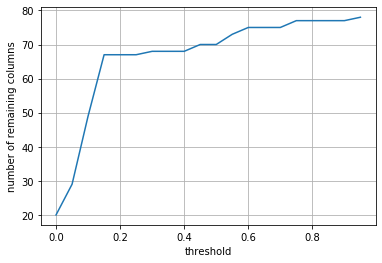

In [11]:
plt.plot(list(num_remain_col.keys()), list(num_remain_col.values()))
plt.xlabel('threshold')
plt.ylabel('number of remaining columns')
plt.grid(True)
plt.show()

*Based on expert judgment the treshold=75%  was selected*

In [12]:
to_drop_75=[]
for i in X_train.columns:
    if X_train.isna().sum()[i]/X_train.shape[0]>0.75:
        to_drop_75.append(i)
X_train.drop(columns=to_drop_75,inplace=True)
X_train.shape

(36000, 77)

### Preprocessing

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36000 entries, 20038 to 15795
Data columns (total 77 columns):
Var6      32013 non-null float64
Var7      32020 non-null float64
Var13     32020 non-null float64
Var21     32013 non-null float64
Var22     32400 non-null float64
Var24     30749 non-null float64
Var25     32400 non-null float64
Var28     32399 non-null float64
Var35     32400 non-null float64
Var38     32400 non-null float64
Var44     32400 non-null float64
Var57     36000 non-null float64
Var65     32020 non-null float64
Var72     19862 non-null float64
Var73     36000 non-null int64
Var74     32020 non-null float64
Var76     32400 non-null float64
Var78     32400 non-null float64
Var81     32013 non-null float64
Var83     32400 non-null float64
Var85     32400 non-null float64
Var94     19862 non-null float64
Var109    30749 non-null float64
Var112    32400 non-null float64
Var113    36000 non-null float64
Var119    32013 non-null float64
Var123    32400 non-null float6

Numeric columns

In [14]:
X_train.loc[:,'Var6':'Var189'] = X_train.loc[:,'Var6':'Var189'].fillna(X_train.loc[:,'Var6':'Var189'].mean())
X_train.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229,target
20038,119.000000,0.000000,4.000000,48.000000,60.000000,0.000000,0.000000,20.080000,0.000000,2.076024e+06,...,1YVfGrO,oslk,fXVEsaq,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,1
23937,1319.489176,6.798876,1247.075328,233.664949,288.889198,4.549611,96.668148,223.973135,0.707716,2.564732e+06,...,EqJsZNf,d0EEeJi,BSis5Dl,LM8l689qOp,NaN,fKCe,02N6s8f,F2FyR07IdsN7I,NaN,-1
6046,1043.000000,7.000000,60.000000,336.000000,420.000000,10.000000,168.000000,200.000000,0.000000,8.866800e+04,...,KtBOw16,oslk,NKvz4Af,LM8l689qOp,kG3k,WqMG,RAYp,55YFVY9,NaN,-1
23187,371.000000,0.000000,0.000000,136.000000,170.000000,2.000000,8.000000,286.960000,0.000000,4.245948e+06,...,Nvc6w_1,oslk,EXUR6zD,LM8l689qOp,NaN,453m,RAYp,0pzBWGkV3fbsGZN52DH,NaN,-1
25421,644.000000,7.000000,0.000000,24.000000,30.000000,0.000000,0.000000,186.640000,0.000000,5.165514e+06,...,FgkjbzC,oslk,5gSwS9i,LM8l689qOp,NaN,uWr3,RAYp,F2FyR07IdsN7I,am7c,-1


Categorical columns

In [15]:
X_train.loc[:,'Var192':'Var229'].head()

,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
20038,a4vvyxLkBI,RO12,NaN,taul,1K8T,OTVu,ka_ns41,GBSi0Jc1XM,NaN,NaN,...,NaN,1YVfGrO,oslk,fXVEsaq,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN
23937,CEat0G8rTN,RO12,NaN,taul,1K8T,AnrR,ehuz2iK,_UtlxbJ,NaN,NaN,...,FzaX,EqJsZNf,d0EEeJi,BSis5Dl,LM8l689qOp,NaN,fKCe,02N6s8f,F2FyR07IdsN7I,NaN
6046,mzKvyx8zhV,2Knk1KF,SEuy,taul,1K8T,0Xwj,ojHCYcI,WeaL,ELe4G18,smXZ,...,FzaX,KtBOw16,oslk,NKvz4Af,LM8l689qOp,kG3k,WqMG,RAYp,55YFVY9,NaN
23187,DHegUHXZeb,RO12,NaN,taul,1K8T,7ALb,7z8szr3,Cy0RhGn,NaN,NaN,...,AT1N,Nvc6w_1,oslk,EXUR6zD,LM8l689qOp,NaN,453m,RAYp,0pzBWGkV3fbsGZN52DH,NaN
25421,5_lq9aXt5a,RO12,NaN,taul,1K8T,4fje,cnWs43J,EXpWEXgaYWQf4,NaN,NaN,...,FzaX,FgkjbzC,oslk,5gSwS9i,LM8l689qOp,NaN,uWr3,RAYp,F2FyR07IdsN7I,am7c


After many checks, it turned out that categorical data does not carry a lot of information. 
Therefore, it was decided to delete them.

In [16]:
col_need=list(X_train.loc[:,'Var6':'Var189'].columns)
col_need.append('target')

In [17]:
X_train_fin=X_train[col_need]
X_train_fin.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189,target
20038,119.000000,0.000000,4.000000,48.000000,60.000000,0.000000,0.000000,20.080000,0.000000,2.076024e+06,...,0.000000,9.000000,0.000000,2.983276e+06,6.000000,5.184000e+05,0.000000,0.000000,18.000000,1
23937,1319.489176,6.798876,1247.075328,233.664949,288.889198,4.549611,96.668148,223.973135,0.707716,2.564732e+06,...,0.055556,11.743042,298175.309799,6.168535e+06,38.541235,4.869868e+05,0.006728,0.613364,270.744403,-1
6046,1043.000000,7.000000,60.000000,336.000000,420.000000,10.000000,168.000000,200.000000,0.000000,8.866800e+04,...,0.000000,0.000000,547785.000000,4.577840e+06,52.000000,1.005516e+06,0.000000,0.000000,270.744403,-1
23187,371.000000,0.000000,0.000000,136.000000,170.000000,2.000000,8.000000,286.960000,0.000000,4.245948e+06,...,0.000000,0.000000,604800.000000,1.064096e+07,30.000000,0.000000e+00,0.000000,0.000000,270.744403,-1
25421,644.000000,7.000000,0.000000,24.000000,30.000000,0.000000,0.000000,186.640000,0.000000,5.165514e+06,...,0.000000,9.000000,0.000000,1.002112e+07,2.000000,0.000000e+00,0.000000,0.000000,270.744403,-1


In [18]:
hold_out.loc[:,'Var6':'Var189'] = hold_out.loc[:,'Var6':'Var189'].fillna(hold_out.loc[:,'Var6':'Var189'].mean())
hold_out.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,target
32823,NaN,NaN,NaN,0.0,NaN,1323.756757,6.731073,83.88,345850.2,8.408163,...,oslk,76DJixu,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,-1
16298,NaN,NaN,NaN,NaN,NaN,2632.000000,7.000000,83.88,345850.2,8.408163,...,d0EEeJi,x3a7KuW,LM8l689qOp,NaN,ELof,Qcbd,nIGXDli,ib5G6X1eUxUn6,mj86,-1
28505,NaN,0.0,192.0,NaN,NaN,1323.756757,6.731073,83.88,345850.2,8.000000,...,oslk,xKQ2fT4,NaN,4n2X,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,-1
6689,NaN,NaN,NaN,NaN,NaN,770.000000,7.000000,83.88,345850.2,8.408163,...,oslk,CnZoIp0,jySVZNlOJy,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,am7c,-1
26893,NaN,NaN,NaN,NaN,NaN,980.000000,0.000000,83.88,345850.2,8.408163,...,Al6ZaUT,JyKROSq,LM8l689qOp,NaN,NaN,FSa2,02N6s8f,xwM2aC7IdeMC0,NaN,-1


In [19]:
hold_out_fin=hold_out[col_need]
hold_out_fin.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189,target
32823,1323.756757,6.731073,1226.027119,235.780405,292.212612,4.141485,92.25,227.291382,0.731027,2.665185e+06,...,0.083705,11.419764,298124.061718,6.352408e+06,40.702009,476520.502232,0.007254,0.585938,269.243669,-1
16298,2632.000000,7.000000,760.000000,676.000000,845.000000,10.000000,416.00,166.560000,0.000000,4.722000e+04,...,0.000000,9.000000,90489.000000,1.307384e+06,134.000000,76296.000000,0.000000,0.000000,269.243669,-1
28505,1323.756757,6.731073,1226.027119,235.780405,292.212612,4.141485,92.25,227.291382,0.731027,2.665185e+06,...,0.083705,11.419764,298124.061718,6.352408e+06,40.702009,476520.502232,0.007254,0.585938,269.243669,-1
6689,770.000000,7.000000,352.000000,136.000000,170.000000,0.000000,32.00,186.640000,0.000000,4.297212e+06,...,0.000000,9.000000,0.000000,1.047808e+07,24.000000,0.000000,0.000000,7.000000,269.243669,-1
26893,980.000000,0.000000,0.000000,384.000000,480.000000,10.000000,288.00,308.400000,0.000000,5.437128e+06,...,0.000000,0.000000,426650.000000,1.056352e+07,40.000000,207864.000000,0.000000,0.000000,269.243669,-1


### Modelling

In [20]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_fin.drop(['target'], axis=1), 
                                                    X_train_fin.target, test_size=0.2, random_state=42)

__Logistic Regression__

In [21]:
log_reg = LogisticRegression()
print(cross_val_score(log_reg,X_train_fin.drop(['target'], axis=1), 
                                                    X_train_fin.target, cv=3,scoring='roc_auc').mean())

0.573726230279956


In [36]:
log_reg = LogisticRegression()
log_reg.fit(X_train_1, y_train_1)
print(f'test: {roc_auc_score(y_test_1, log_reg.predict_proba(X_test_1)[:, 1])}')
print(f'hold-out:',
roc_auc_score(hold_out_fin['target'], log_reg.predict_proba(hold_out_fin.drop(['target'], axis=1))[:, 1]))

test: 0.609031178097326
hold-out: 0.6147919100061183


In [37]:
# accuracy score
from sklearn.metrics import accuracy_score
print(f'test accuracy: {accuracy_score(y_test_1, log_reg.predict(X_test_1))}')
print(f'hold-out accuracy:',
accuracy_score(hold_out_fin['target'], log_reg.predict(hold_out_fin.drop(['target'], axis=1))))

test accuracy: 0.9275
hold-out accuracy: 0.922


__Random forest__

In [38]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
print(cross_val_score(clf,X_train_fin.drop(['target'], axis=1), 
                                                    X_train_fin.target, cv=3,scoring='roc_auc').mean())

0.6885323329539043


In [39]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train_1, y_train_1)
print(f'test: {roc_auc_score(y_test_1, clf.predict_proba(X_test_1)[:, 1])}')
print(f'hold-out:',
roc_auc_score(hold_out_fin['target'], clf.predict_proba(hold_out_fin.drop(['target'], axis=1))[:, 1]))

test: 0.6812363417421783
hold-out: 0.6807442884754435


In [40]:
 #accuracy score
print(f'test accuracy: {accuracy_score(y_test_1, clf.predict(X_test_1))}')
print(f'hold-out accuracy:',
accuracy_score(hold_out_fin['target'], clf.predict(hold_out_fin.drop(['target'], axis=1))))

test accuracy: 0.9280555555555555
hold-out accuracy: 0.922


__Gradient boosting__

In [41]:
xg_reg_fin = xgb.XGBClassifier()
print(cross_val_score(xg_reg_fin,X_train_fin.drop(['target'], axis=1), 
                                                    X_train_fin.target, cv=3,scoring='roc_auc').mean())

0.7192441496572166


In [42]:
xg_reg = xgb.XGBClassifier()
xg_reg.fit(X_train_1, y_train_1)
print(f'test: {roc_auc_score(y_test_1, xg_reg.predict_proba(X_test_1)[:, 1])}')
print(f'hold-out:',
roc_auc_score(hold_out_fin['target'], xg_reg.predict_proba(hold_out_fin.drop(['target'], axis=1))[:, 1]))

test: 0.7182677717697172
hold-out: 0.7212481401913344


In [43]:
 #accuracy score
print(f'test accuracy: {accuracy_score(y_test_1, xg_reg.predict(X_test_1))}')
print(f'hold-out accuracy:',
accuracy_score(hold_out_fin['target'], xg_reg.predict(hold_out_fin.drop(['target'], axis=1))))

test accuracy: 0.9283333333333333
hold-out accuracy: 0.92275


__Tuning parameters__

In [28]:
xg_reg.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [29]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6,7]
        } 

In [30]:
model = xgb.XGBClassifier()
clf=RandomizedSearchCV(model,params,scoring='roc_auc')
clf.fit(X=X_train_fin.drop(['target'], axis=1), y=X_train_fin.target)
print(clf.best_params_)

{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0, 'colsample_bytree': 0.8}


__Final model__

In [44]:
xg_reg_mod = xgb.XGBClassifier(subsample= 0.8, min_child_weight=10, max_depth= 4,
                           gamma=0, colsample_bytree= 0.8)
xg_reg_mod.fit(X_train_1, y_train_1)
print(f'test: {roc_auc_score(y_test_1, xg_reg_mod.predict_proba(X_test_1)[:, 1])}')
print(f'hold-out:',
roc_auc_score(hold_out_fin['target'], xg_reg_mod.predict_proba(hold_out_fin.drop(['target'], axis=1))[:, 1]))

test: 0.7197920651228045
hold-out: 0.7230166965626564


In [45]:
 #accuracy score
print(f'test accuracy: {accuracy_score(y_test_1, xg_reg_mod.predict(X_test_1))}')
print(f'hold-out accuracy:',
accuracy_score(hold_out_fin['target'], xg_reg_mod.predict(hold_out_fin.drop(['target'], axis=1))))

test accuracy: 0.9281944444444444
hold-out accuracy: 0.92225
